Importing relevant packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



# Imports for the MLP Regressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

2023-07-03 18:10:12.842610: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 18:10:13.357338: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 18:10:13.359758: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 18:10:16.391826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading the dataset and printing first 3 rows:

In [2]:
df = pd.read_csv('../data/PETR4.SA.csv', parse_dates=['Date'], index_col='Date')
df.head(3)

Open   High    Low  Close  Adj Close        Volume
Date                                                           
2000-01-03  5.875  5.875  5.875  5.875   1.563740  3.538944e+10
2000-01-04  5.550  5.550  5.550  5.550   1.477235  2.886144e+10
2000-01-05  5.494  5.494  5.494  5.494   1.462330  4.303360e+10

Let's have a look at some statistics:

In [3]:
df.describe()

Open         High          Low        Close    Adj Close  \
count  5898.000000  5898.000000  5898.000000  5898.000000  5898.000000   
mean     19.141195    19.417342    18.843884    19.125684     6.989928   
std       9.528718     9.663342     9.377653     9.519757     4.737233   
min       4.200000     4.270000     4.120000     4.200000     1.164487   
25%      10.400938    10.550000    10.228125    10.401250     3.157507   
50%      19.549999    19.900000    19.270000    19.549999     6.395513   
75%      26.180000    26.600000    25.790001    26.200001     9.218781   
max      52.580002    53.680000    51.950001    52.509998    31.850000   

             Volume  
count  5.898000e+03  
mean   5.493729e+08  
std    3.893731e+09  
min    0.000000e+00  
25%    2.150572e+07  
50%    3.476770e+07  
75%    5.601185e+07  
max    7.356416e+10

Evolution of the closing stock price from 01/2000 to 06/2023:

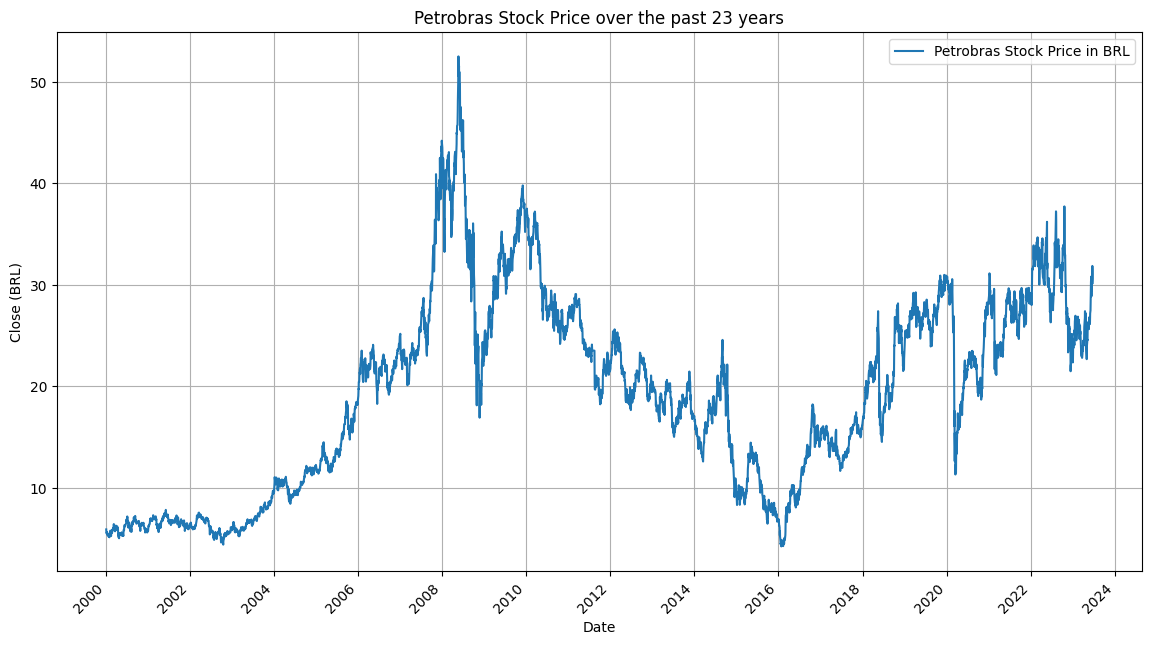

In [4]:
import matplotlib.dates as mdates

plt.figure(figsize=(14,7))
sns.lineplot(x=df.index, y=df['Close'], label='Petrobras Stock Price in BRL')

plt.ylabel('Close (BRL)')
plt.title('Petrobras Stock Price over the past 23 years')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid(True)

Same plot, but grouped by 10 days to reduce noise and improve readability:

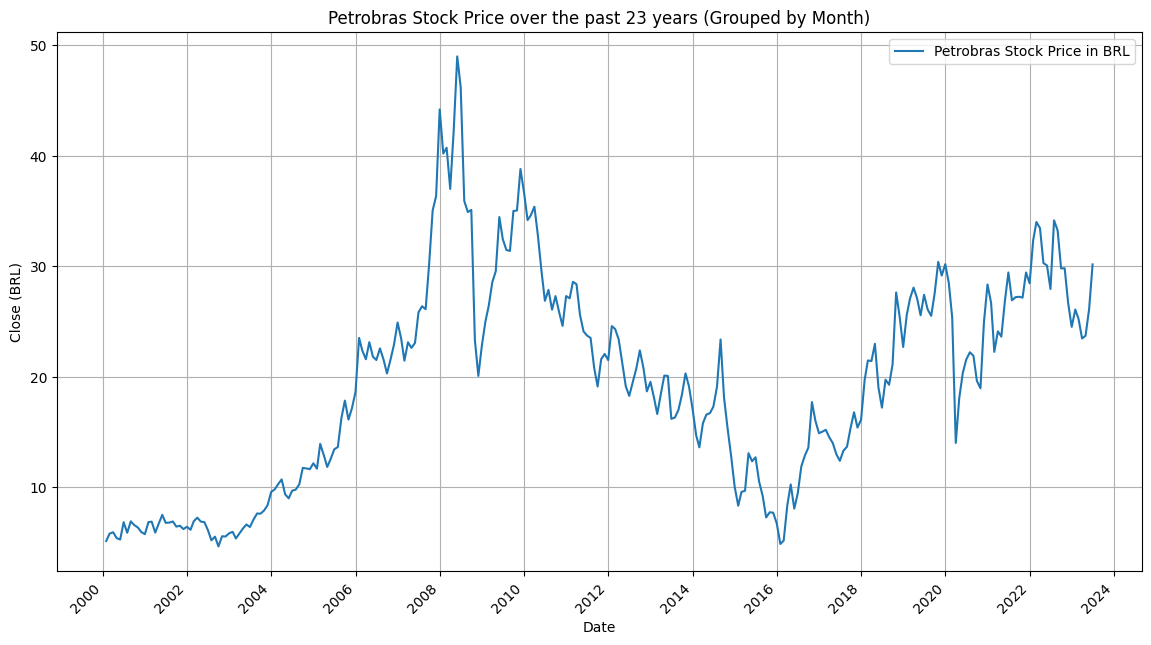

In [5]:

plt.figure(figsize=(14,7))
sns.lineplot(x=df.resample('1M').last().index, y=df.resample('1M').last()['Close'], label='Petrobras Stock Price in BRL')

plt.ylabel('Close (BRL)')
plt.title('Petrobras Stock Price over the past 23 years (Grouped by Month)')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid(True)

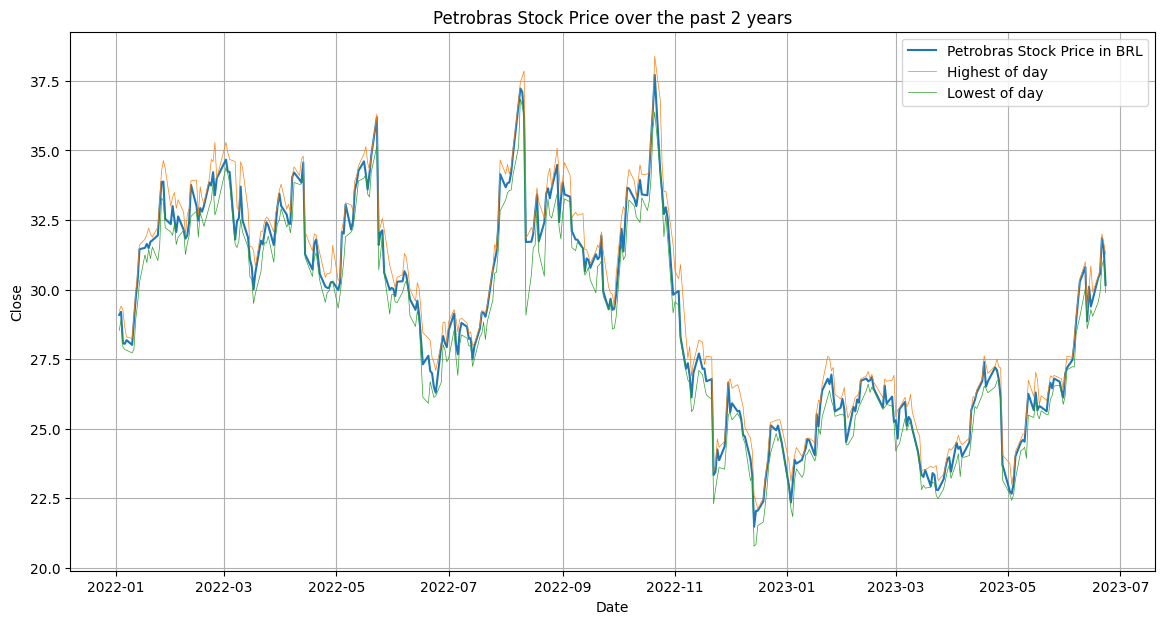

In [6]:
plt.figure(figsize=(14,7))

data_2023 = df.loc['2022':'2023']
sns.lineplot(x=data_2023.index, y=data_2023['Close'], label='Petrobras Stock Price in BRL')
sns.lineplot(x=data_2023.index, y=data_2023['High'], label='Highest of day', linewidth=0.5)
sns.lineplot(x=data_2023.index, y=data_2023['Low'], label='Lowest of day', linewidth=0.5)
plt.title('Petrobras Stock Price over the past 2 years')
plt.grid(True);

In [7]:
import plotly.graph_objects as go

# assuming the index is a DatetimeIndex
data_2023 = df.loc['2022':'2023']

fig = go.Figure()

fig.add_trace(go.Scatter(x=data_2023.index, y=data_2023['Close'], name='Petrobras Stock Price in BRL'))
fig.add_trace(go.Scatter(x=data_2023.index, y=data_2023['High'], name='Highest of day', line=dict(width=0.5)))
fig.add_trace(go.Scatter(x=data_2023.index, y=data_2023['Low'], name='Lowest of day', line=dict(width=0.5)))

fig.update_layout(title='Petrobras Stock Price over the past 2 years', xaxis_title='Date', yaxis_title='Price (BRL)', showlegend=True, legend=dict(x=0, y=1))

fig.show()

Correlation plot:

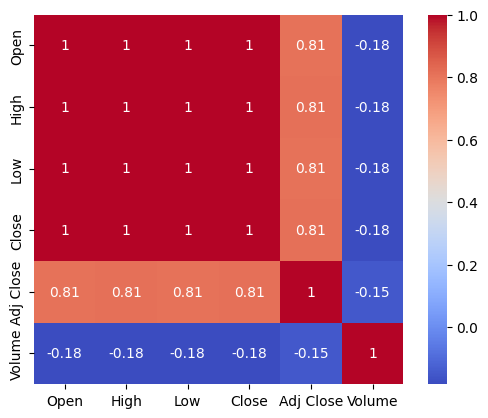

In [8]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', square=True);

Checking the distribution of the closing price:

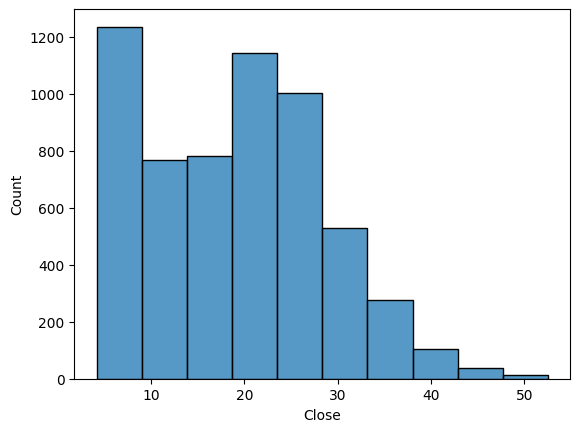

In [9]:
sns.histplot(df['Close'], bins=10);

In [10]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Moving average (smoothing the time series)

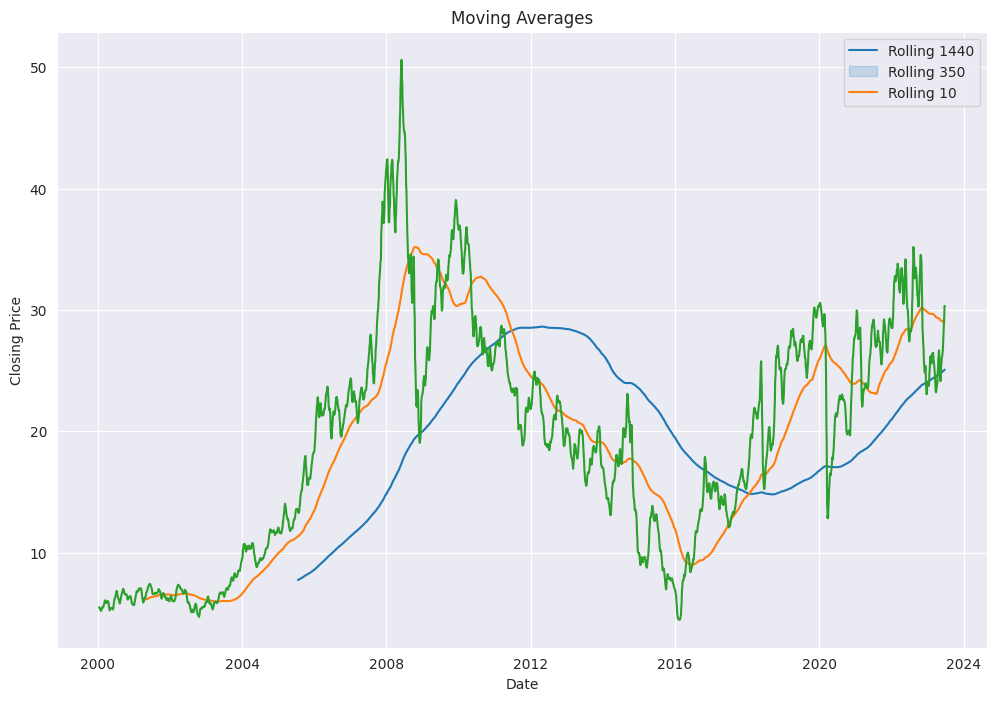

In [11]:
rolling_ten = df['Close'].rolling(window=10).mean()
rolling_tri = df['Close'].rolling(window=350).mean()
rolling_sem = df['Close'].rolling(window=1440).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(12, 8))
sns.lineplot(x=df.index, y=rolling_sem)
sns.lineplot(x=df.index, y=rolling_tri)
sns.lineplot(x=df.index, y=rolling_ten)
plt.legend(['Rolling 1440', 'Rolling 350', 'Rolling 10'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Moving Averages')
plt.show()

# Predicting the stock price with ML

## Baseline model (whole dataset)

Selecting the desired series

In [12]:
close = df['Close']

In [13]:
close.describe()

count    5898.000000
mean       19.125684
std         9.519757
min         4.200000
25%        10.401250
50%        19.549999
75%        26.200001
max        52.509998
Name: Close, dtype: float64

In [14]:
print(f'The dataset is composed of {close.size} working days')

The dataset is composed of 5898 working days


In [15]:
close_base = pd.concat([close, close.shift(1)], axis=1)

In [16]:
close_base.columns = ['Close', 'Forecast_Close']

In [17]:
close_base.dropna(inplace=True)

In [18]:
close_error = mean_squared_error(close_base.Close, close_base.Forecast_Close)

In [19]:
f'The mean error of the base line model is {round(np.sqrt(close_error),2)} BRL'

'The mean error of the base line model is 0.56 BRL'

## Baseline model (2023 dataset)

Selecting 2023 year only

In [20]:
close_2023 = close.loc['2023-01-01':]

In [21]:
close_2023_base = pd.concat([close_2023, close_2023.shift(1)], axis=1)

In [22]:
close_2023_base.columns = ['Close', 'Forecast_Close']
close_2023_base.dropna(inplace=True)

In [23]:
close_2023_error = mean_squared_error(close_2023_base.Close, close_2023_base.Forecast_Close)

In [24]:
f'The mean error of the base line model is {round(np.sqrt(close_2023_error),2)} BRL'

'The mean error of the base line model is 0.64 BRL'

# Finding the order for the ARIMA MODEL

### ACF and PACF plots

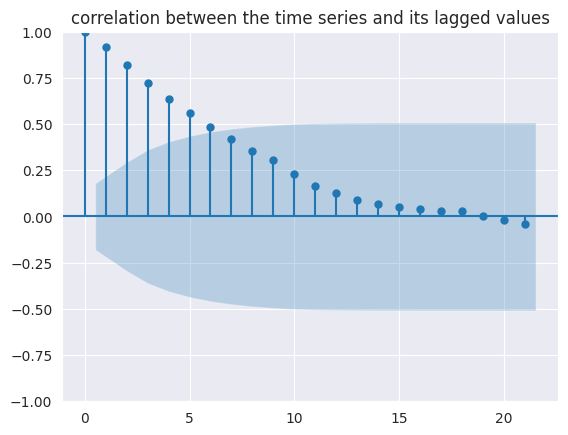

In [25]:
plot_acf(close_2023)
plt.title('correlation between the time series and its lagged values');

Based on the point at which the ACF plot cuts off above, we chose q ~ 5 or 6

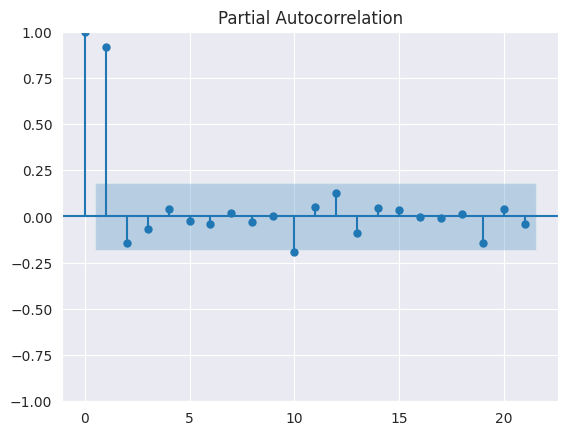

In [26]:
plot_pacf(close_2023)
plt.show()

The plot above displays the correlation between the time series and its lagged values after controlling for the effects of all shorter lags. We choose the value p=1

## Building the ARIMA model (2023 dataset)

In [27]:
training_set = int(close_2023.shape[0]*0.8)

close_2023_train = close_2023[:training_set]
close_2023_test = close_2023[training_set:]
print(close_2023_train.shape, close_2023_test.shape)

(95,) (24,)


In [28]:
model_2023 = ARIMA(close_2023_train, order=(1, 0, 6))

In [29]:
model_2023_fit = model_2023.fit()

Let's check the AIC of the model.  The AIC is a measure of the relative quality of a statistical model, taking into account the tradeoff between the complexity of the model and its ability to fit the data.

In [30]:
model_2023_fit.aic

183.02227228071555

In [31]:
model_2023_forecast = model_2023_fit.forecast(steps=close_2023_test.shape[0])

np.sqrt(mean_squared_error(close_2023_test, model_2023_forecast))

3.9103323572686337

Issue to create series, so will create manually temporarily

In [32]:
# create the DatetimeIndex
dates = pd.to_datetime(['2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25',
                        '2023-05-26', '2023-05-29', '2023-05-30', '2023-05-31',
                        '2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06',
                        '2023-06-07', '2023-06-09', '2023-06-12', '2023-06-13',
                        '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-19',
                        '2023-06-20', '2023-06-21', '2023-06-22', '2023-06-23'])

# create the dataframe with the column of interest
df = pd.DataFrame({'values': [25.630445, 25.550692, 25.417263, 25.361151, 25.299825,
                              25.240011, 25.191422, 25.151951, 25.119888, 25.093841,
                              25.072683, 25.055495, 25.041533, 25.030191, 25.020977,
                              25.013493, 25.007413, 25.002474, 24.998462, 24.995203,
                              24.992555, 24.990404, 24.988657, 24.987238]})

# set the DatetimeIndex as the index of the dataframe
df.set_index(dates, inplace=True)

(array([19358., 19389., 19417., 19448., 19478., 19509., 19539.]),
 [Text(19358.0, 0, '2023-01'),
  Text(19389.0, 0, '2023-02'),
  Text(19417.0, 0, '2023-03'),
  Text(19448.0, 0, '2023-04'),
  Text(19478.0, 0, '2023-05'),
  Text(19509.0, 0, '2023-06'),
  Text(19539.0, 0, '2023-07')])

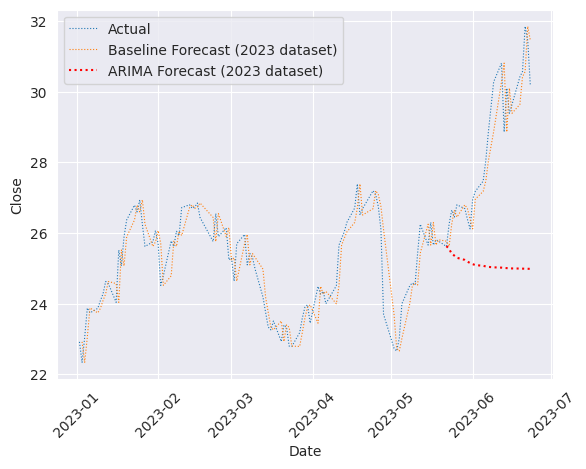

In [33]:
# sns.lineplot(close_2023, label='Actual', linewidth=0.9)
sns.lineplot(close_2023, label='Actual', linewidth=0.8, linestyle=':')
sns.lineplot(close_2023_base.Forecast_Close, label='Baseline Forecast (2023 dataset)', linewidth=0.8, linestyle=':')
sns.lineplot(x=df.index, y='values', data=df, label='ARIMA Forecast (2023 dataset)', linestyle=':', color='red');
plt.xticks(rotation=45)

The Baseline model seems to do a much better job at predicting than the ARIMA model for this case. Let's loop throuhg p, q and d, to find an optimum value so the ARIMA model can be improved

In [34]:
p_values = range(0,5)
d_values = range(0,3)
q_values = range(0,7)

In [35]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            train_size = int(close_2023.shape[0]*0.8)
            train, test = close_2023[:train_size], close_2023[train_size:]
            predictions = ()
            model = ARIMA(train, order=(p,d,q))
            model_fit = model.fit()
            pred_y = model_fit.forecast(steps=test.shape[0])
            error = mean_squared_error(test, pred_y)
            if np.sqrt(error) < 3:
                print(np.sqrt(error), p, d, q)

2.873318597069158 0 2 1
2.880058498321125 0 2 2
2.875002714670191 0 2 3
2.869778312390336 0 2 4
2.8696853366390753 0 2 5
2.8952475222455987 0 2 6
2.9415841642148743 1 2 0
2.8808615452985102 1 2 1
2.8855651088248906 1 2 2
2.860313010349436 1 2 3
2.89278802666984 1 2 4
2.886067551506041 1 2 5
2.895889117015973 1 2 6
2.876778100908164 2 2 1
2.863502509195357 2 2 2
2.7538110986004165 2 2 3
2.72220576844202 2 2 4
2.733845172702621 2 2 5
2.9277001262106097 2 2 6
2.871086226400738 3 2 1
2.8957777288296467 3 2 2
2.7298806921046306 3 2 3
2.977860778689891 3 2 4
2.7593574850693976 3 2 5
2.964077445706436 3 2 6
2.8666553445000917 4 2 1
2.8862827636656583 4 2 2
2.7257244881610823 4 2 3
2.9930285846490903 4 2 4
2.8606677940834975 4 2 5
2.8448552438277463 4 2 6


We find the optimum values for p, d and q to be 2, 2 and 4, respectively. But still the baseline model is performing much better than the ARIMA model.

## Let's try using the entire dataset instead of 2023 only

In [36]:
close_whole = close_base.Close

In [37]:
training_size = int(close_whole.shape[0]*0.8)

whole_2023_train = close_whole[0:training_size]
whole_2023_test = close_whole[training_size:]
print(whole_2023_train.shape, whole_2023_test.shape)

(4717,) (1180,)


In [38]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            model = ARIMA(whole_2023_train, order=(p,d,q))
            model_fit = model.fit()
            pred_y = model_fit.forecast(steps=whole_2023_test.shape[0])
            error = mean_squared_error(whole_2023_test, pred_y)
            print(np.sqrt(error), p, d, q)

10.12421513238568 0 0 0
10.12491410872689 0 0 1
10.12485502153032 0 0 2
10.125200339440783 0 0 3
10.124838400848695 0 0 4
10.123362047076343 0 0 5
10.12497329053979 0 0 6
8.226823966688597 0 1 0
8.21878591101389 0 1 1
8.22666050377048 0 1 2
8.242744554776186 0 1 3
8.214745232851891 0 1 4
8.210375336895545 0 1 5
8.22267489583372 0 1 6
409.07494399139046 0 2 0
6.910605710882441 0 2 1
6.662850335804533 0 2 2
6.6855287841253475 0 2 3
6.687525372462246 0 2 4
6.657453213314097 0 2 5
6.654003782204185 0 2 6
9.291302387264153 1 0 0
9.809111927407725 1 0 1
9.298536248237454 1 0 2
9.255638753063124 1 0 3
9.282691308408763 1 0 4
9.309469826531952 1 0 5
9.279709493917562 1 0 6
8.21885507382469 1 1 0
8.219432026043934 1 1 1
8.239465236506208 1 1 2
8.233318781074312 1 1 3
8.21119381425598 1 1 4
8.210378839332552 1 1 5
8.223811932311897 1 1 6
290.9831575235389 1 2 0
6.726787263184677 1 2 1
6.671239387867019 1 2 2
6.662604241745046 1 2 3
6.671823246087197 1 2 4
6.695152017905041 1 2 5
6.67292982905015

In [39]:
model = ARIMA(whole_2023_train, order=(4,2,6))
model_fit = model.fit()
pred_y = model_fit.forecast(steps=whole_2023_test.shape[0])
error = mean_squared_error(whole_2023_test, pred_y)
np.sqrt(error)

6.628385901517597

We see that for the whole dataset, the MSE of the ARIMA model is still greater than the MSE for the baseline model, meaning that the baseline models is the best choice as of now.  

# Models MSE in summary:

In [40]:
print(f"Baseline Model MSE (entire dataset): {round(np.sqrt(close_error),2)}\nARIMA MSE (entire dataset): {np.round(np.sqrt(error),2)}\nBaseline Model MSE (2023): {round(np.sqrt(close_2023_error),2)}\nARIMA Model MSE (2023): 2.72")

Baseline Model MSE (entire dataset): 0.56
ARIMA MSE (entire dataset): 6.63
Baseline Model MSE (2023): 0.64
ARIMA Model MSE (2023): 2.72


# Performing a forecast using an MLP Model

### Preparing the 2023 dataset

In [41]:
# Divide the x_train y X_trainclose_2023, ref: https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

Considering the univariate sequence below:

In [42]:
close_2023.head()

Date
2023-01-02    22.920000
2023-01-03    22.340000
2023-01-04    23.049999
2023-01-05    23.879999
2023-01-06    23.740000
Name: Close, dtype: float64

In [43]:
index_2023 = close_2023.index
index_2023

DatetimeIndex(['2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11',
               '2023-01-12', '2023-01-13',
               ...
               '2023-06-12', '2023-06-13', '2023-06-14', '2023-06-15',
               '2023-06-16', '2023-06-19', '2023-06-20', '2023-06-21',
               '2023-06-22', '2023-06-23'],
              dtype='datetime64[ns]', name='Date', length=119, freq=None)

We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned. The split_sequence() function below implements this behavior and will split a given univariate sequence into multiple samples where each sample has a specified number of time steps and the output is a single time step.

In [44]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

We can then apply the function above in the 2023 dataset to define X and y:

In [45]:
n_steps = 3
X, y = split_sequence(close_2023, n_steps)
print(X.shape, y.shape)

(116, 3) (116,)


In [124]:
train_size = 0.8
length = int(X.shape[0]*0.8)
X_train, y_train = X[:length], y[:length]
X_test, y_test = X[length:], y[length:]
print(X_test.shape, y_test.shape)

(24, 3) (24,)


### Instantiating the MLP model

In [47]:
# Defining model
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Once the model is defined, we can fit it on the training dataset:

In [48]:
model_fit = model.fit(X_train, y_train, epochs=600, verbose=0)

In [49]:
X_train.shape

(92, 3)

In [50]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 201ms/step


In [51]:
mlp_error = mean_squared_error(y_test, y_pred)
mlp_mse = round(np.sqrt(mlp_error),2)
print(f"The MSE for the MLP model is: {mlp_mse} BRL")

The MSE for the MLP model is: 0.85 BRL


Preparing dataset for plots (with date index):

In [141]:
tmp_plot = pd.DataFrame(close_2023[length:][3:]) # Selecting portion of dataset with date index and adding
tmp_plot['pred'] = y_pred

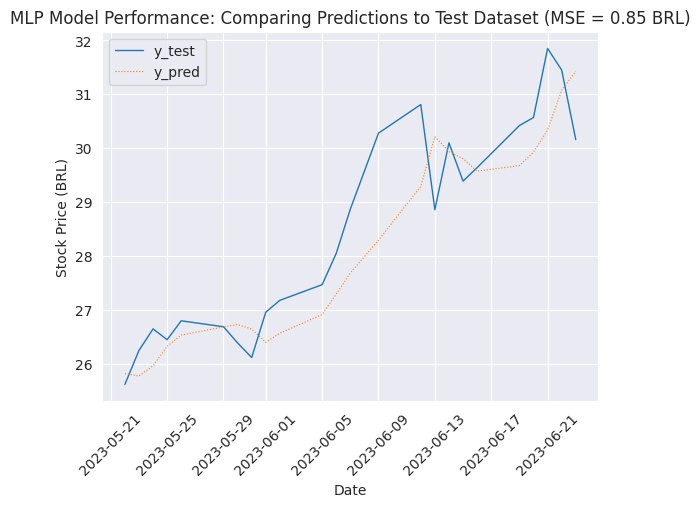

In [145]:
sns.lineplot(tmp_plot['Close'], label='y_test', linewidth=1)
sns.lineplot(tmp_plot['pred'], label='y_pred', linewidth=0.8, linestyle=':')
plt.title(f"MLP Model Performance: Comparing Predictions to Test Dataset (MSE = {mlp_mse} BRL)")
plt.ylabel('Stock Price (BRL)')
plt.xlabel('Date')
plt.xticks(rotation=45)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:2], labels=labels[:2]);

Source: https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

## Fix the label 0

## Add dates in the x axis

## Try different N-steps

## Try to improve model's performance

## Make a real prediction and check the actual values. 

## End od Project

Splitting Train & Test data

In [10]:
df_close = df[['Close']]

In [11]:
n_train = int(len(df_close) * 0.8)
n_test = len(df_close) - n_train

# We divide them, except the 
train, test = df_close.iloc[:n_train], df.iloc[n_train:len(df_close)]

print(f'Train: {len(train)}\nTest length: {len(test)}')

Train: 4718
Test length: 1180


Convert to Time Series Data

In [46]:
train

Close
Date                 
2000-01-03   5.875000
2000-01-04   5.550000
2000-01-05   5.494000
2000-01-06   5.475000
2000-01-07   5.500000
...               ...
2018-09-11  18.500000
2018-09-12  18.950001
2018-09-13  18.709999
2018-09-14  18.790001
2018-09-17  19.400000

[4718 rows x 1 columns]

In [27]:
lr = 0.0001 
optimizer = Adam(learning_rate=lr)

model = Sequential()
model.add(Dense(50, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
pipeline = make_pipeline(MinMaxScaler(), model)

history = model.fit(X_train, y_train, epochs=300)

Epoch 1/300
148/148 [==============================] - 2s 5ms/step - loss: 317.1137
Epoch 2/300
148/148 [==============================] - 1s 4ms/step - loss: 80.0807
Epoch 3/300
148/148 [==============================] - 1s 4ms/step - loss: 11.0926
Epoch 4/300
148/148 [==============================] - 1s 4ms/step - loss: 1.2107
Epoch 5/300
148/148 [==============================] - 1s 4ms/step - loss: 0.5187
Epoch 6/300
148/148 [==============================] - 1s 4ms/step - loss: 0.4913
Epoch 7/300
148/148 [==============================] - 1s 5ms/step - loss: 0.4892
Epoch 8/300
148/148 [==============================] - 1s 5ms/step - loss: 0.4867
Epoch 9/300
148/148 [==============================] - 1s 4ms/step - loss: 0.4834
Epoch 10/300
148/148 [==============================] - 1s 4ms/step - loss: 0.4786
Epoch 11/300
148/148 [==============================] - 1s 4ms/step - loss: 0.4723
Epoch 12/300
148/148 [==============================] - 1s 4ms/step - loss: 0.4634
Epoch 13/

In [35]:
X_new_transformed = pipeline.named_steps['minmaxscaler'].transform(X_test)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [28]:
y_pred = model.predict(X_test)

37/37 [==============================] - 0s 4ms/step


In [29]:
y_pred.shape

(1174, 6, 1)

In [30]:
y_pred = y_pred.reshape(1174,6)

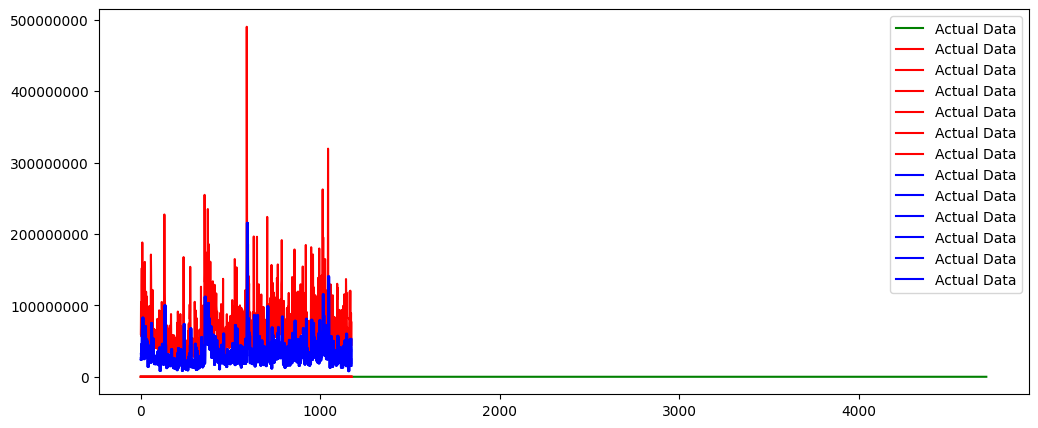

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,5))
fig.set_dpi(100)

plt.plot(y_train, label="Actual Data", color='g')
plt.plot(y_test, label="Actual Data", color='r')
plt.plot(y_pred, label="Actual Data", color='b')

plt.gca().ticklabel_format(style='plain', axis='y') # set y-axis format to plain

plt.legend()
plt.show()

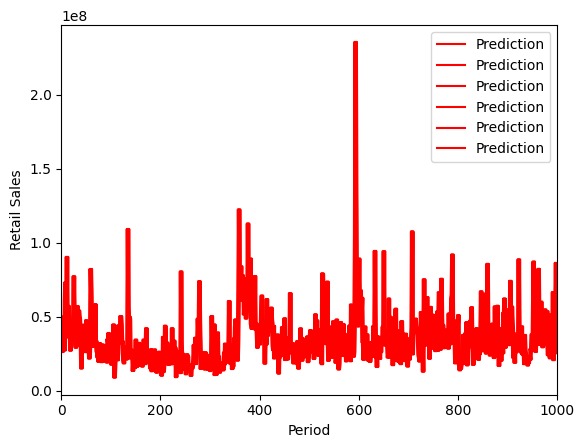

In [55]:

plt.plot(y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()

plt.show();

In [ ]:
df['Vol.'] = df['Vol.'].str.replace('M', '').astype('float64')*10**6
df.info()
df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2023-06-23 to 2023-01-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   120 non-null    float64
 1   Vol.    119 non-null    float64
dtypes: float64(2)
memory usage: 2.8 KB


/tmp/ipykernel_8154/1359166843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vol.'] = df['Vol.'].str.replace('M', '').astype('float64')*10**6
/tmp/ipykernel_8154/1359166843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119 entries, 2023-06-23 to 2023-01-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   119 non-null    float64
 1   Vol.    119 non-null    float64
dtypes: float64(2)
memory usage: 2.8 KB


<Axes: xlabel='Date', ylabel='Price'>

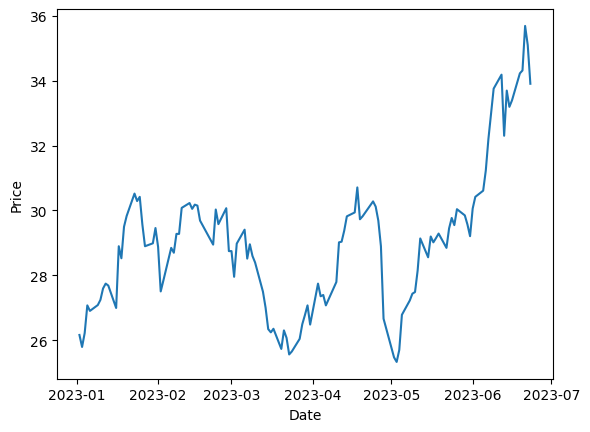

In [ ]:
sns.lineplot(x='Date', y='Price', data=df)

In [ ]:
df.head()

Price        Vol.
Date                         
2023-06-23  33.90  11740000.0
2023-06-22  35.09  13630000.0
2023-06-21  35.68  16980000.0
2023-06-20  34.31  20060000.0
2023-06-19  34.22   5670000.0

continue with a time series while await response

In [ ]:
# Generate sample data for training
X = np.random.rand(100, 5)  # Input features (e.g., historical demand, price, etc.)
y = np.random.rand(100)     # Target variable (e.g., demand)

# Scale the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', solver='adam', random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f"R^2 Score: {score}")

# Make predictions on new data
new_data = np.random.rand(5)  # New input features
new_data_scaled = scaler.transform(new_data.reshape(1, -1))
prediction = model.predict(new_data_scaled)
print(f"Predicted demand: {prediction}")

R^2 Score: -0.15759178213164926
Predicted demand: [0.39117564]


In [ ]:
y.shape

(100,)

In [ ]:
# Generate sample data for training
X = df[['Price']].values # Input features (e.g., historical demand, price, etc.)
y = df['Price']     # Target variable (e.g., demand)

# Scale the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f"R^2 Score: {score}")

# Make predictions on new data
new_data = pd.DataFrame()  # New input features
new_data_scaled = scaler.transform(new_data.reshape(1, -1))
prediction = model.predict(new_data_scaled)
print(f"Predicted demand: {prediction}")

R^2 Score: -6.482635456344343


/home/fmaron/.pyenv/versions/petropredict/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ValueError: at least one array or dtype is required

array([33.9 , 35.09, 35.68, 34.31, 34.22, 33.39, 33.19, 33.69, 32.3 ,
       34.18, 33.75, 32.2 , 31.23, 30.61, 30.42, 30.06, 29.21, 29.57,
       29.85, 30.04, 29.55, 29.77, 29.45, 28.85, 29.29, 29.15, 29.02,
       29.2 , 28.56, 29.14, 28.15, 27.49, 27.44, 27.23, 26.79, 25.71,
       25.34, 25.48, 26.67, 28.9 , 29.69, 30.12, 30.28, 29.82, 29.73,
       30.71, 29.94, 29.82, 29.38, 29.04, 29.02, 27.8 , 27.08, 27.4 ,
       27.36, 27.75, 26.49, 27.08, 26.78, 26.5 , 26.05, 25.66, 25.57,
       26.08, 26.31, 25.74, 26.36, 26.25, 26.35, 27.01, 27.5 , 28.4 ,
       28.6 , 28.96, 28.52, 29.41, 28.98, 27.96, 28.75, 28.75, 30.07,
       29.58, 30.03, 28.95, 29.69, 30.15, 30.18, 30.05, 30.23, 30.08,
       29.28, 29.28, 28.7 , 28.85, 27.84, 27.51, 28.88, 29.46, 28.99,
       28.9 , 29.57, 30.42, 30.29, 30.52, 29.83, 29.5 , 28.53, 28.9 ,
       27.  , 27.69, 27.75, 27.6 , 27.25, 27.09, 26.91, 27.08, 26.23,
       25.8 , 26.17])